In [1]:
#######################################################################################################
#Import Modules
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import calendar

Although the compositions of S&P500 Index change from time to time, I attempt to choose the top 5 out of top 200 current holdings for backtesting - more convenient when writing the program

In [2]:
#######################################################################################################
#Extract S&P500 Index Top200 Stickers
tickers = pd.read_csv('SP500_Holdings.csv')
tickers = tickers['Symbol'].iloc[:200].values.tolist()

In [3]:
#######################################################################################################
#Initialize variables (start date, end date, number of stocks to be selected as winners)
start = '2017-08-01'
end = '2022-07-31'
num_of_stocks = 5

In [4]:
#######################################################################################################
#Import data from yahoo finance API
df = yf.download(tickers, start = start, end = end)
prices = df['Adj Close']
print(prices.head())

[*********************100%***********************]  200 of 200 completed
                    A       AAPL       ABBV        ABT         ACN  \
Date                                                                 
2017-07-31  57.514080  35.150581  55.601017  45.289791  119.227570   
2017-08-01  57.658371  35.462555  55.974819  45.262169  120.190117   
2017-08-02  57.908474  37.138199  56.237282  45.335831  119.042450   
2017-08-03  58.072006  36.767147  56.459965  45.271374  120.338211   
2017-08-04  57.841148  36.960938  56.459965  45.363461  120.504807   

                  ADBE        ADI        ADM         ADP        ADSK  ...  \
Date                                                                  ...   
2017-07-31  146.490005  71.659904  36.421719  107.100464  110.790001  ...   
2017-08-01  147.360001  71.605484  37.388805  105.182007  111.379997  ...   
2017-08-02  147.130005  71.487602  36.689388  103.803963  109.129997  ...   
2017-08-03  147.789993  70.689453  36.801643  100.6

In [5]:
#######################################################################################################
#Calculate the winners in each week
daily_return = np.log(prices/prices.shift(1))
weekly_return = daily_return.resample('W').agg(lambda x: x.sum())
weekly_winners_index = weekly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)

#Calculate the winners in each month
monthly_return = daily_return.resample('M').agg(lambda x: x.sum())
monthly_winners_index = monthly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)

print("Weekly Winners: \n", weekly_winners_index.head())
print("Monthly Winners: \n",monthly_winners_index.head())

Weekly Winners: 
 Date
2017-08-06    Index(['ILMN', 'TSLA', 'HUM', 'AAPL', 'TMUS'],...
2017-08-13    Index(['CMCSA', 'CSX', 'LRCX', 'CHTR', 'KLAC']...
2017-08-20    Index(['MU', 'EL', 'ISRG', 'LRCX', 'LIN'], dty...
2017-08-27    Index(['FCX', 'IQV', 'ADSK', 'DG', 'JCI'], dty...
2017-09-03    Index(['GILD', 'ILMN', 'MU', 'ADI', 'MCHP'], d...
Freq: W-SUN, dtype: object
Monthly Winners: 
 Date
2017-07-31    Index(['A', 'AAPL', 'ABBV', 'ABT', 'ACN'], dty...
2017-08-31    Index(['ILMN', 'MU', 'CNC', 'HUM', 'AAPL'], dt...
2017-09-30    Index(['MU', 'ABBV', 'DVN', 'AMAT', 'COP'], dt...
2017-10-31    Index(['INTC', 'ADBE', 'NVDA', 'AMZN', 'IQV'],...
2017-11-30    Index(['QCOM', 'AZO', 'COST', 'EW', 'ZTS'], dt...
Freq: M, dtype: object


In [6]:
#######################################################################################################
#Buy the winners (each in equal proportions) at the end of this week and hold them for one week
weekly_strategy = pd.DataFrame()

for i in range(len(weekly_winners_index) - 1):
    weekly_winners = weekly_winners_index[i].values.tolist()
    weekend = weekly_return.index[i+1]
    weekly_winners_return = daily_return.loc[weekend-timedelta(days = 6):weekend-timedelta(days = 2), weekly_return.columns.isin(weekly_winners)]
    weekly_winners_return['mean return'] = weekly_winners_return.mean(axis = 1)
    weekly_strategy = weekly_strategy.append(weekly_winners_return)


weekly_strategy = weekly_strategy['mean return']

In [7]:
#######################################################################################################
#Buy the winners (each in equal proportions) at the end of this month and hold them for one month
monthly_strategy = pd.DataFrame()

for i in range(len(monthly_winners_index) - 1):
    monthly_winners = monthly_winners_index[i].values.tolist()
    monthend = pd.to_datetime(monthly_return.index[i+1], format = '%Y-%m-%d')
    daysInMonth= int(calendar.monthrange(monthend.year, monthend.month)[1])
    monthly_winners_return = daily_return.loc[monthend-timedelta(days = daysInMonth-1):monthend, monthly_return.columns.isin(monthly_winners)]
    monthly_winners_return['mean return'] = monthly_winners_return.mean(axis = 1)
    monthly_strategy = monthly_strategy.append(monthly_winners_return)

monthly_strategy = monthly_strategy['mean return']

In [8]:
#######################################################################################################
#Assign S&P500 Index as our benchmark
sp500 = yf.download('SPY', start = start, end = end)
sp500['returns'] = np.log(sp500['Adj Close']/sp500['Adj Close'].shift(1))

[*********************100%***********************]  1 of 1 completed


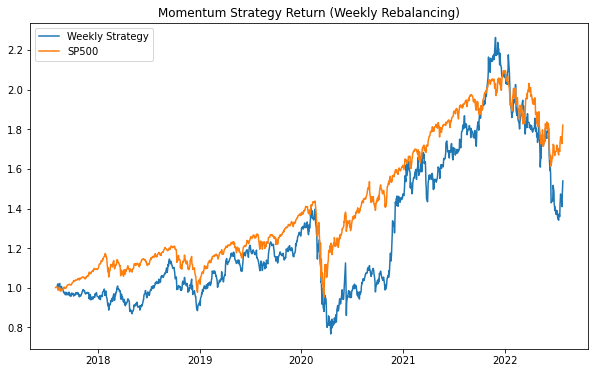

In [9]:
#######################################################################################################
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Weekly Rebalancing)')
ax.plot(weekly_strategy.cumsum().apply(np.exp), label = 'Weekly Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.legend()


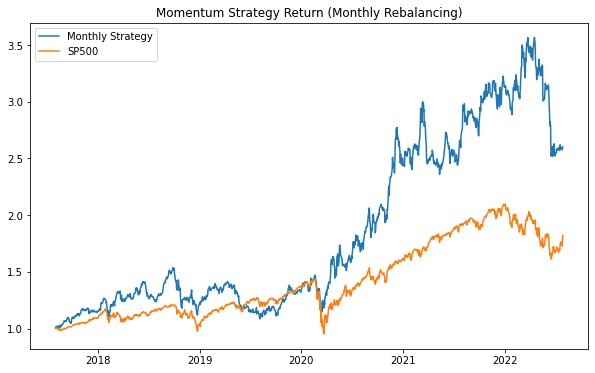

In [10]:
#######################################################################################################
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Monthly Rebalancing)')
ax.plot(monthly_strategy.cumsum().apply(np.exp), label = 'Monthly Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.legend()

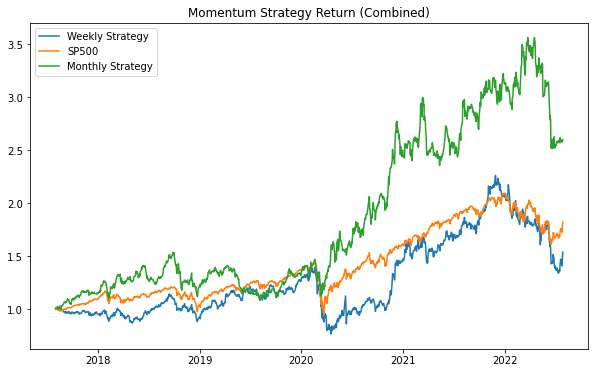

In [11]:
#######################################################################################################
#Combined Graphs
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Combined)')
ax.plot(weekly_strategy.cumsum().apply(np.exp), label = 'Weekly Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.plot(monthly_strategy.cumsum().apply(np.exp), label = 'Monthly Strategy')
ax.legend()

In [12]:
#######################################################################################################
#Compile Annualized Returns

weekly_endval = np.exp(weekly_strategy.sum())
monthly_endval = np.exp(monthly_strategy.sum())
NumOfDays = (pd.to_datetime(end, format = '%Y-%m-%d') - pd.to_datetime(start, format = '%Y-%m-%d')).days
weekly_annualizedreturn = weekly_endval ** (365/ NumOfDays) - 1
monthly_annualizedreturn = monthly_endval ** (365/ NumOfDays) - 1
print('Number of days = ', NumOfDays)
print('Weekly Strategy - Annualized Return = ', weekly_annualizedreturn)
print('Monthly Strategy - Annualized Return = ', monthly_annualizedreturn)

Number of days =  1825
Weekly Strategy - Annualized Return =  0.09006029400111437
Monthly Strategy - Annualized Return =  0.21075715118646565
